# Init
Install and import libraries, set up logging.

In [1]:
!pip install librosa
!pip install soundfile
!pip install speechbrain

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 824.8/824.8 kB 19.8 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.5/117.5 kB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 722.2/722.2 kB 41.2 MB/s eta 0:00:00


In [2]:
import numpy as np
import librosa
import matplotlib.pyplot as plt
import soundfile as sf

import logging

from speechbrain.inference.vocoders import HIFIGAN
from speechbrain.inference.TTS import Tacotron2
from speechbrain.lobes.models.FastSpeech2 import mel_spectogram

import IPython.display as ipd

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.utils.rnn import pad_sequence
import torchaudio

from datasets import load_dataset # Expresso dataset
import tqdm.notebook

In [3]:
for handler in logging.root.handlers[:]:
    logging.root.removeHandler(handler)

logging.basicConfig(filename='transformer.log', 
                    level=logging.DEBUG,
                    format='%(asctime)s - %(levelname)s - %(message)s')

assert torch.cuda.is_available()
device = torch.device("cuda")
print("Using device:", device)

Using device: cuda


# Utils
Define utility functions and load processed dataset.

In [4]:
EPS = 1e-6

def equals(a, b):
    return abs(a - b) < EPS

def dtw(a, b):
    n, m = a.shape[0], b.shape[0]
    dtw_matrix = np.full((n + 1, m + 1), np.inf)
    dtw_matrix[0, 0] = 0

    for i in range(1, n + 1):
        for j in range(1, m + 1):
            cost = np.linalg.norm(a[i - 1] - b[j - 1])  # Euclidean distance
            dtw_matrix[i, j] = cost + min(dtw_matrix[i - 1, j],    # Insertion
                                           dtw_matrix[i, j - 1],    # Deletion
                                           dtw_matrix[i - 1, j - 1]) # Match

    # Backtrack to find the optimal path
    i, j = n, m
    path = []

    while i > 0 or j > 0:
        path.append((i - 1, j - 1))
        if i > 0 and j > 0:
            if equals(dtw_matrix[i, j], dtw_matrix[i - 1, j - 1] + np.linalg.norm(a[i - 1] - b[j - 1])):
                i -= 1
                j -= 1
            elif equals(dtw_matrix[i, j], dtw_matrix[i - 1, j] + np.linalg.norm(a[i - 1] - b[j - 1])):
                i -= 1
            else:
                j -= 1
        elif i > 0:
            i -= 1
        else:
            j -= 1

    path.reverse()
    return dtw_matrix[n, m], path

def load_audio(file_path):
    y, sr = librosa.load(file_path, sr=None)
    return y, sr

def align(signal_a, signal_b, path):
    aligned_b = np.zeros_like(signal_a)

    for idx_a, idx_b in path:
        aligned_b[idx_a] = signal_b[idx_b]

    return aligned_b

def main(audio_file_1, audio_file_2):
    
    # 0. Load audio files
    audio_a, sr_a = load_audio(audio_file_1)
    audio_b, sr_b = load_audio(audio_file_2)

    # 1. Extract MFCC features
    mfcc_a = librosa.feature.mfcc(y=audio_a, sr=sr_a, n_mfcc=13).T
    mfcc_b = librosa.feature.mfcc(y=audio_b, sr=sr_b, n_mfcc=13).T

    # 2. Normalise MFCC features
    mfcc_a_normalised = (mfcc_a - np.mean(mfcc_a, axis=0))/(np.std(mfcc_a, axis=0))
    mfcc_b_normalised = (mfcc_b - np.mean(mfcc_b, axis=0))/(np.std(mfcc_b, axis=0))

    # 3. Perform DTW
    _, path = dtw(mfcc_a_normalised, mfcc_b_normalised)

    # 4. Align audio_b using DTW path
    mfcc_b_aligned = align_mfcc(mfcc_a_normalised, mfcc_b, path)
    audio_b_aligned = librosa.feature.inverse.mfcc_to_audio(np.einsum("ij->ji", mfcc_b_aligned))

    # 5. Export
    sf.write(f'./{audio_file_2}_aligned.wav', audio_b_aligned, sr_b)
    print(f"Aligned audio saved as '{audio_file_2}_aligned.wav'.")

    return

def naive_cut(audio_file_1, audio_file_2):
    audio_a, _ = load_audio(audio_file_1)
    audio_b, sr_b = load_audio(audio_file_2)
    sf.write('./audio_b_cut.wav', audio_b[:len(audio_a)], sr_b)
    print("Aligned audio saved as 'audio_b_cut.wav'.")

def naive_speed(audio_file_1, audio_file_2):
    audio_a, sr_a = load_audio(audio_file_1)
    audio_b, _ = load_audio(audio_file_2)
    sf.write('./audio_b_speed.wav', audio_b, int(sr_a*len(audio_b)/len(audio_a)))
    print("Aligned audio saved as 'audio_b_speed.wav'.")

In [5]:
# Load a pretrained HIFIGAN Vocoder
tacotron2 = Tacotron2.from_hparams(source="speechbrain/tts-tacotron2-ljspeech", savedir="tmpdir_tts")
hifi_gan = HIFIGAN.from_hparams(source="speechbrain/tts-hifigan-ljspeech", savedir="tmpdir_vocoder")

def view_spectrogram(spectrogram, title="Mel Spectrogram", n_mels=80):
    if not isinstance(spectrogram, np.ndarray):
        spectrogram = spectrogram.numpy()
    if spectrogram.shape[0] != 80:
        spectrogram = np.einsum("ij->ji", spectrogram)
    assert spectrogram.shape[0] == n_mels, f"spectrogram shape {spectrogram.shape} != ({n_mels}, seq_length)"
    print(spectrogram.shape)
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(spectrogram, sr=22050, x_axis='time', y_axis='mel', fmax=8000)
    plt.colorbar(format='%+2.0f dB')
    plt.title(title)
    plt.tight_layout()
    plt.show()

def get_spectrogram(file_name):

    signal, rate = torchaudio.load(file_name)
    signal = torchaudio.functional.resample(signal, orig_freq=rate, new_freq=22050)

    spectrogram, _ = mel_spectogram(
        audio=signal.squeeze(),
        sample_rate=22050,
        hop_length=256,
        win_length=None,
        n_mels=80,
        n_fft=1024,
        f_min=0.0,
        f_max=8000.0,
        power=1,
        normalized=False,
        min_max_energy_norm=True,
        norm="slaney",
        mel_scale="slaney",
        compression=True
    )

    return spectrogram

def get_spectrogram_from_waveform(signal, rate):
    
    if isinstance(signal, np.ndarray):
        signal = torch.tensor(signal, dtype=torch.float32)
    
    signal = torchaudio.functional.resample(signal, orig_freq=rate, new_freq=22050)

    spectrogram, _ = mel_spectogram(
        audio=signal.squeeze(),
        sample_rate=22050,
        hop_length=256,
        win_length=None,
        n_mels=80,
        n_fft=1024,
        f_min=0.0,
        f_max=8000.0,
        power=1,
        normalized=False,
        min_max_energy_norm=True,
        norm="slaney",
        mel_scale="slaney",
        compression=True
    )

    return spectrogram

def spectrogram_to_waveform(spectrogram, save_file_name):
    waveforms = hifi_gan.decode_batch(spectrogram) # spectrogram to waveform
    torchaudio.save(save_file_name, waveforms.squeeze(1), 22050)

def get_reconstructed_sample(file_name, save_file_name):

    signal, rate = torchaudio.load(file_name)
    signal = torchaudio.functional.resample(signal, orig_freq=rate, new_freq=22050)

    spectrogram, _ = mel_spectogram(
        audio=signal.squeeze(),
        sample_rate=22050,
        hop_length=256,
        win_length=None,
        n_mels=80,
        n_fft=1024,
        f_min=0.0,
        f_max=8000.0,
        power=1,
        normalized=False,
        min_max_energy_norm=True,
        norm="slaney",
        mel_scale="slaney",
        compression=True
    )

    waveforms = hifi_gan.decode_batch(spectrogram) # spectrogram to waveform

    torchaudio.save(save_file_name, waveforms.squeeze(1), 22050)

def transcript_to_audio(sentence, save_file_name):
    
    mel_output, mel_length, alignment = tacotron2.encode_text(sentence)
    # 1. Mel spectrogram with properties in the Tacotron paper (or see get_reconstructed_sample)
    #    Shape = (batch_size, n_mels=80, Mel_length + 1); Mel_length proportional to length of sequence
    # 2. Mel_length = mel_output.shape[2] - 1
    # 3. Alignment
    #    Shape = (batch_size, Mel_length, Token_length) where Token_length is from tacotron2.text_to_seq(txt)

    waveforms = hifi_gan.decode_batch(mel_output) # spectrogram to waveform

    torchaudio.save(save_file_name, waveforms.squeeze(1), 22050)

def transcript_to_mel(sentence):
    mel_output, mel_length, alignment = tacotron2.encode_text(sentence)
    return mel_output.squeeze() # remove the batch dimension

def mel_to_audio(mel_output, save_file_name=None, display=False):
    if isinstance(mel_output, np.ndarray):
        mel_output = torch.tensor(mel_output)
    if mel_output.shape[0] != 80:
        mel_output = torch.einsum("ij->ji", mel_output)
    waveforms = hifi_gan.decode_batch(mel_output) # spectrogram to waveform
    if save_file_name is not None: torchaudio.save(save_file_name, waveforms.squeeze(1), 22050)
    if display: return ipd.Audio(waveforms, rate=22050)
    return waveforms

def sample_audio(dataset, idx:int):
    print(dataset[idx])
    mel_to_audio(torch.einsum("ij->ji", dataset[idx]["data_mel"]), f"sample_{idx}.wav")
    mel_to_audio(torch.einsum("ij->ji", torch.tensor(dataset[idx]["original_data_mel"])), f"sample_{idx}_original.wav")

hyperparams.yaml:   0%|          | 0.00/2.20k [00:00<?, ?B/s]

model.ckpt:   0%|          | 0.00/113M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/speechbrain/utils/checkpoints.py:200: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(path, map_location=device

hyperparams.yaml:   0%|          | 0.00/1.16k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/torch/nn/utils/weight_norm.py:134: FutureWarning: `torch.nn.utils.weight_norm` is deprecated in favor of `torch.nn.utils.parametrizations.weight_norm`.
  WeightNorm.apply(module, name, dim)


generator.ckpt:   0%|          | 0.00/55.8M [00:00<?, ?B/s]

In [6]:
dataset = torch.load("/kaggle/input/speaker4/speaker4.pth")

<ipython-input-6-20d2d04c0571>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  dataset = torch.load("/kaggle/input/speaker4/speaker4.pth")


# Visualise
Visualise Mel spectrograms, audios, and standardise Mel spectrograms per channel.

In [7]:
dataset.keys()

dict_keys(['training_data', 'validation_data', 'testing_data'])

In [8]:
dataset["training_data"][0]

{'ai_mel': tensor([[-7.8492, -7.3307, -6.6301,  ..., -8.0682, -8.1318, -8.2108],
         [-7.2794, -6.9274, -6.0865,  ..., -4.3011, -4.4681, -4.6947],
         [-7.0368, -6.4330, -5.6233,  ..., -3.3078, -3.5027, -3.6652],
         ...,
         [-9.2401, -7.9647, -7.0248,  ..., -9.5332, -9.6661, -9.7794],
         [-8.8494, -7.7307, -6.9419,  ..., -9.4397, -9.5681, -9.6655],
         [-7.6389, -6.9217, -6.4373,  ..., -8.9684, -9.0957, -9.2034]]),
 'data_mel': tensor([[ -4.2457,  -5.4113,  -6.5330,  ...,  -9.4975,  -9.9039, -10.0626],
         [ -3.9257,  -4.8880,  -5.3662,  ...,  -7.3940,  -7.8090,  -7.5819],
         [ -3.3474,  -4.3667,  -5.2441,  ...,  -7.1020,  -7.2266,  -7.1720],
         ...,
         [ -4.8205,  -5.3937,  -6.7073,  ..., -11.4210, -10.9578, -10.9433],
         [ -4.8774,  -6.0056,  -7.2092,  ..., -11.2542, -11.0340, -11.1805],
         [ -6.3306,  -6.6870,  -7.6659,  ..., -11.5129, -11.5129, -11.5129]]),
 'label': tensor([0]),
 'speaker': tensor([3]),
 'original

In [9]:
mu = torch.zeros(80)
x_square = torch.zeros(80)
sig = torch.zeros(80)
tot = 0

for item in dataset["training_data"]:
    tot += item["ai_mel"].size(0)
    curmu = item["ai_mel"].sum(axis=0)
    mu = mu + curmu
    x_square = x_square + (item["ai_mel"]**2).sum(axis=0)

mu /= tot
sig = torch.sqrt(x_square/tot - mu*mu)

In [10]:
mu_cuda = mu.to(device)
sig_cuda = sig.to(device)
mu_cuda, sig_cuda

(tensor([-7.4990, -6.5328, -5.3987, -4.4837, -3.7761, -3.5434, -3.6160, -3.8005,
         -3.9782, -3.9691, -3.7469, -3.6308, -3.6504, -3.8282, -3.9266, -4.0730,
         -4.0767, -4.1129, -4.2296, -4.4473, -4.7190, -4.9743, -5.2267, -5.2257,
         -5.2633, -5.2845, -5.4200, -5.4644, -5.5488, -5.6251, -5.7137, -5.7661,
         -5.7753, -5.7592, -5.8325, -5.6921, -5.6649, -5.5181, -5.4869, -5.5082,
         -5.4662, -5.5150, -5.6501, -5.8251, -5.9818, -6.1024, -6.2278, -6.3062,
         -6.1691, -6.0324, -5.9821, -5.9031, -5.8066, -5.7475, -5.7100, -5.7397,
         -5.8021, -5.8439, -5.8004, -5.7638, -5.7784, -5.9207, -6.0986, -6.2570,
         -6.3363, -6.3704, -6.4147, -6.4102, -6.3860, -6.5412, -6.8810, -7.3639,
         -7.8558, -8.1350, -8.0716, -7.7136, -7.3699, -7.1712, -7.1088, -7.0696],
        device='cuda:0'),
 tensor([0.8041, 0.6678, 0.8381, 1.4564, 1.7739, 1.8248, 1.6570, 1.5014, 1.7045,
         1.7582, 1.7670, 1.7874, 1.7832, 1.7321, 1.6639, 1.6572, 1.7116, 1.7598,
 

In [11]:
mu_data = torch.zeros(80)
x_square_data = torch.zeros(80)
sig_data = torch.zeros(80)
tot_data = 0

for item in dataset["training_data"]:
    tot_data += item["data_mel"].size(0)
    curmu_data = item["data_mel"].sum(axis=0)
    mu_data = mu_data + curmu_data
    x_square_data = x_square_data + (item["data_mel"]**2).sum(axis=0)

mu_data /= tot_data
sig_data = torch.sqrt(x_square_data/tot_data - mu_data*mu_data)

In [12]:
mu_data_cuda = mu_data.to(device)
sig_data_cuda = sig_data.to(device)
mu_data_cuda, sig_data_cuda

(tensor([-3.9282, -5.1092, -5.7251, -5.3474, -4.6980, -4.2515, -4.1140, -4.2480,
         -4.3631, -4.4402, -4.3544, -4.4137, -4.4313, -4.5160, -4.5863, -4.7744,
         -4.8714, -4.9012, -4.9360, -4.9804, -4.9970, -4.9148, -4.9718, -4.9861,
         -5.0030, -4.9890, -5.1187, -5.1374, -5.1883, -5.2733, -5.3792, -5.4862,
         -5.5539, -5.6198, -5.7677, -5.7315, -5.7823, -5.7668, -5.7563, -5.7873,
         -5.8331, -5.8523, -5.8665, -5.8505, -5.8624, -5.8915, -5.9453, -5.9887,
         -6.0072, -6.0022, -6.0324, -6.0569, -6.0942, -6.0737, -6.0278, -5.9865,
         -5.9661, -6.0345, -6.1290, -6.2002, -6.2437, -6.2543, -6.2691, -6.2997,
         -6.3496, -6.4997, -6.6987, -6.9175, -7.1360, -7.3277, -7.5055, -7.6644,
         -7.7616, -7.8089, -7.8083, -7.7373, -7.6116, -7.4555, -7.3392, -7.2968],
        device='cuda:0'),
 tensor([1.1561, 1.1746, 1.3542, 1.6120, 1.9996, 2.1902, 2.2102, 2.1403, 2.0660,
         2.0012, 1.9782, 2.0021, 2.0061, 2.0088, 1.9906, 1.9911, 2.0081, 2.0369,
 

(80, 343)


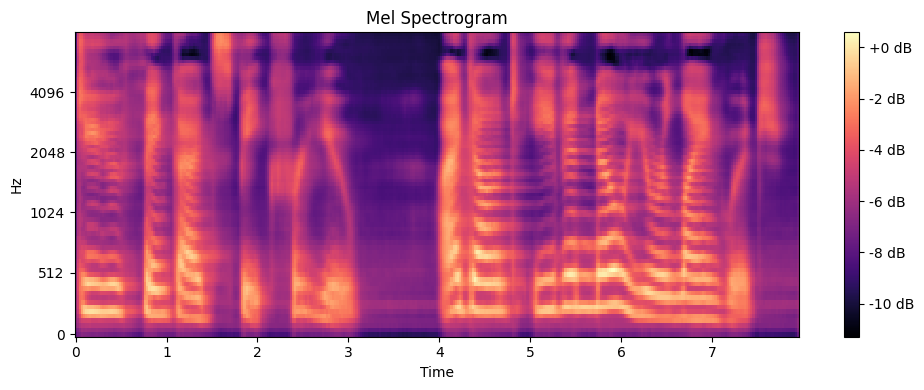

In [13]:
view_spectrogram(dataset["training_data"][0]["ai_mel"], title="Mel Spectrogram")

(80, 343)


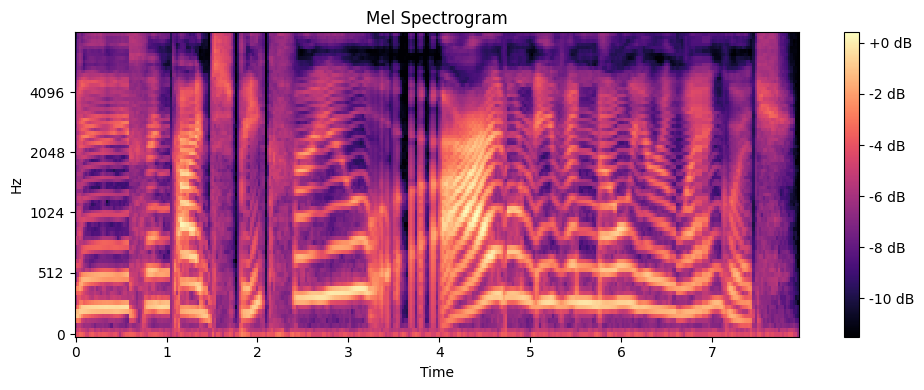

In [14]:
view_spectrogram(dataset["training_data"][0]["data_mel"], title="Mel Spectrogram")

In [15]:
mel_to_audio(dataset["training_data"][1]["ai_mel"], display=True)

In [16]:
mel_to_audio(dataset["training_data"][1]["data_mel"], display=True)

In [17]:
class ProcessedMelSpectrogramDataset(torch.utils.data.Dataset):
    def __init__(self, split, data):
        assert split in ("train", "valid", "test"), "invalid split"
        m = {
            "train": "training_data",
            "valid": "validation_data",
            "test": "testing_data"
        }
        self.data = data
        self.split = m[split]
        
        import random
        random.seed(225) # reproducibility
        random.shuffle(self.data["training_data"])

    def __len__(self):
        return len(self.data[self.split])

    def __getitem__(self, idx:int):
        assert idx >= 0 and idx < len(self), "Index error in ProcessedMelSpectrogramDataset"
        return self.data[self.split][idx]
    
    @staticmethod
    def collate(batch):
        
        assert torch.cuda.is_available()
        device = torch.device("cuda")
        
        ai_mel = pad_sequence(
            [item["ai_mel"] for item in batch],
            batch_first=True, padding_value=np.nan
        )
        data_mel = pad_sequence(
            [item["data_mel"] for item in batch],
            batch_first=True, padding_value=np.nan
        )
#         duration = pad_sequence(
#             [item["duration"] for item in batch],
#             batch_first=True, padding_value=np.nan
#         )
        labels = torch.cat(tuple([item["label"] for item in batch]))
#         sequence_lengths = torch.cat(tuple([item["sequence_length"] for item in batch]))
        mask = torch.all(torch.where(torch.isnan(ai_mel), torch.full(ai_mel.shape, True), torch.full(ai_mel.shape, False)), 2)
        mask_check = torch.all(torch.where(torch.isnan(data_mel), torch.full(data_mel.shape, True), torch.full(data_mel.shape, False)), 2)
#         mask_double_check = torch.where(torch.isnan(duration), torch.full(duration.shape, True), torch.full(duration.shape, False))
        assert torch.equal(mask, mask_check), "mask is dubious"
#         assert torch.equal(mask, mask_double_check), f"mask is dubious {mask.shape}, {mask_double_check.shape}"

        ai_mel = pad_sequence(
            [(item["ai_mel"] - mu)/sig for item in batch],
            batch_first=True, padding_value=0.0
        )
        data_mel = pad_sequence(
            [(item["data_mel"] - mu_data)/sig_data for item in batch],
            batch_first=True, padding_value=0.0
        )
#         duration = pad_sequence(
#             [item["duration"] for item in batch],
#             batch_first=True, padding_value=0.0
#         )
        
        batch_size = len(batch)
        _, ai_mel_max_length, _ = ai_mel.shape
        assert ai_mel.shape == (batch_size, ai_mel_max_length, 80)
        assert data_mel.shape == ai_mel.shape
#         assert duration.shape == ai_mel.shape[:2]
#         assert sequence_lengths.shape == torch.Size([batch_size])
#         assert torch.all(sequence_lengths > 0), "not all sequence lengths are positive"
        assert mask.shape == ai_mel.shape[:2]
        
        return {
            "ai_mel": ai_mel.to(device),
            "data_mel": data_mel.to(device), 
            "labels": labels.to(device),
#             "sequence_length": sequence_lengths.to(device),
            "mask": mask.to(device) #,
#             "duration": duration.to(device)
        }

# Model
Define and initialise transformer model.

In [18]:
class EmotionModel(nn.Module):
    def transform(self, batch):
        raise NotImplementedError()

    def compute_loss(self, batch):
        batch_size, seq_length, mels_dim = batch["ai_mel"].shape
        assert batch["data_mel"].shape == (batch_size, seq_length, mels_dim)

        predicted_mel = self.transform(batch)
        assert predicted_mel.shape == (batch_size, seq_length, mels_dim)

        target_mel = batch["data_mel"]
        assert target_mel.shape == (batch_size, seq_length, mels_dim)

        assert mels_dim == 80
        loss = torch.sum((predicted_mel - target_mel)**2)
        return loss
  
    def get_validation_metric(self, validation_dataset, batch_size=64):
        dataset = validation_dataset # replace because of caching efficiency
        data_loader = torch.utils.data.DataLoader(
            dataset, batch_size=batch_size, collate_fn=dataset.collate
        )
        self.eval()
        total_mse = 0.0
        total = 0
        with torch.no_grad():
            for i, batch in enumerate(data_loader):
                loss = self.compute_loss(batch)
                total_mse += loss
                total += batch["ai_mel"].size(0)

        return total_mse/total

In [19]:
class AddPositionalEncoding(nn.Module):
    def __init__(self, d_model=256, input_dropout=0.1, timing_dropout=0.1, max_len=2048):
        super().__init__()
        self.max_len = max_len
        self.timing_table = nn.Parameter(torch.zeros(max_len))
        nn.init.normal_(self.timing_table)
        self.input_dropout = nn.Dropout(input_dropout)
        self.timing_dropout = nn.Dropout(timing_dropout)

    def forward(self, x, mask):
        batch_size, seq_length, d_model = x.shape
        assert x.shape == (batch_size, seq_length, d_model)
        assert mask.shape == (batch_size, seq_length)
        assert seq_length < self.max_len
        x = self.input_dropout(x)
        timing = self.timing_table[:seq_length]
        timing = self.timing_dropout(timing)
        assert timing.shape == (seq_length,), f"{timing.shape}"
        assert timing.unsqueeze(0).unsqueeze(2).shape == (1, seq_length, 1), f"{timing.unsqueeze(0).unsqueeze(2).shape}"
        assert (x + timing.unsqueeze(0).unsqueeze(2)).shape == (batch_size, seq_length, d_model), f"{(x + timing.unsqueeze(0).unsqueeze(2)).shape}"
        assert mask.unsqueeze(-1).expand(-1, -1, d_model).shape == (batch_size, seq_length, d_model), f"{mask.unsqueeze(-1).expand(-1, -1, d_model)}"
        return torch.where(mask.unsqueeze(-1).expand(-1, -1, d_model)==False, x + timing.unsqueeze(0).unsqueeze(2), x)

class TransformerEmotionModel(EmotionModel):
    def __init__(self, d_model=512, num_encoder_layers=6, dropout=0.1):
        super().__init__()
        self.n_mels = 80
        self.d_model = d_model
        self.add_timing = AddPositionalEncoding(d_model)
        self.num_encoder_layers = num_encoder_layers
        encoder_ls = []
        for _ in range(num_encoder_layers):
            encoder_ls.append(nn.TransformerEncoderLayer(d_model=d_model, nhead=8, batch_first=True, norm_first=False, dropout=dropout, dim_feedforward=d_model))
        self.encoder_layers = nn.ModuleList(encoder_ls)
        self.embedding_layer = nn.Embedding(11, d_model) # len(self.label_encoder) = 11
        self.pre_projection_layer = nn.Linear(self.n_mels, d_model)
        self.post_projection_layer = nn.Linear(d_model, self.n_mels)

    def transform(self, batch):
        
        batch_size, seq_length, _ = batch["ai_mel"].shape
        assert batch["ai_mel"].shape == (batch_size, seq_length, self.n_mels)
        
        batch_input = batch["ai_mel"]
        assert batch_input.shape == (batch_size, seq_length, self.n_mels)
        assert not torch.any(torch.isnan(batch_input))

        label = batch["labels"]
        mask = batch["mask"]
        
        assert mask.shape == (batch_size, seq_length)
        assert not torch.any(torch.isnan(mask))
        mask = torch.cat((torch.full((batch_size, 1), False).to(device), mask), 1)
        assert mask.shape == (batch_size, 1 + seq_length)
        
        assert label.shape == (batch_size,)
        label_embedded = self.embedding_layer(label).unsqueeze(1)
        assert label_embedded.shape == (batch_size, 1, self.d_model)
        assert not torch.any(torch.isnan(label_embedded))
        
        pre_adjoined = self.pre_projection_layer(batch_input)
        assert pre_adjoined.shape == (batch_size, seq_length, self.d_model)
        assert not torch.any(torch.isnan(pre_adjoined))
        
        adjoined = torch.cat((label_embedded, pre_adjoined), 1)
        assert adjoined.shape == (batch_size, 1 + seq_length, self.d_model)
        assert not torch.any(torch.isnan(adjoined))
        
        adjoined_with_timing = self.add_timing(adjoined, mask)
        assert adjoined_with_timing.shape == (batch_size, 1 + seq_length, self.d_model)
        assert not torch.any(torch.isnan(adjoined_with_timing))
        
        after_encoder = adjoined_with_timing
        
        for i in range(self.num_encoder_layers):
            after_encoder = self.encoder_layers[i](after_encoder, src_key_padding_mask=mask)
            assert after_encoder.shape == (batch_size, 1 + seq_length, self.d_model)
            assert not torch.any(torch.isnan(after_encoder)) # ERROR
        
        post_adjoined = self.post_projection_layer(after_encoder)
        assert post_adjoined.shape == (batch_size, 1 + seq_length, self.n_mels)
        assert not torch.any(torch.isnan(post_adjoined))
        
        res = post_adjoined[:,1:,:]
        assert res.shape == (batch_size, seq_length, self.n_mels)
        assert not torch.any(torch.isnan(res)) # ERROR
        
        return res

In [21]:
transformer_encoder_model = TransformerEmotionModel(d_model=512, num_encoder_layers=6, dropout=0.1)
transformer_encoder_model.to(device)
#transformer_encoder_model.load_state_dict(torch.load("/kaggle/input/speaker_2/pytorch/default/1/transformer_encoder_model_speaker_two.pt"))
#transformer_encoder_model.load_state_dict(torch.load("/kaggle/working/transformer_encoder_model_speaker_two_new.pt"))

TransformerEmotionModel(
  (add_timing): AddPositionalEncoding(
    (input_dropout): Dropout(p=0.1, inplace=False)
    (timing_dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder_layers): ModuleList(
    (0-5): 6 x TransformerEncoderLayer(
      (self_attn): MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=512, out_features=512, bias=True)
      )
      (linear1): Linear(in_features=512, out_features=512, bias=True)
      (dropout): Dropout(p=0.1, inplace=False)
      (linear2): Linear(in_features=512, out_features=512, bias=True)
      (norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      (norm2): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      (dropout1): Dropout(p=0.1, inplace=False)
      (dropout2): Dropout(p=0.1, inplace=False)
    )
  )
  (embedding_layer): Embedding(11, 512)
  (pre_projection_layer): Linear(in_features=80, out_features=512, bias=True)
  (post_projection_layer): Linear(in_features=512, out_features

# Train
Train loop.

In [22]:
# Training
loss_curve = []
validation_curve = []

In [23]:
def train_processed(model, data, num_epochs, batch_size, model_file,
          learning_rate=8e-4, loss_curve=[], validation_curve=[], best_metric=None):
    training_dataset = ProcessedMelSpectrogramDataset("train", data)
    validation_dataset = ProcessedMelSpectrogramDataset("valid", data)
    
    data_loader = torch.utils.data.DataLoader(
        training_dataset, batch_size=batch_size, shuffle=True, collate_fn=training_dataset.collate
    )
    optimizer = torch.optim.Adam(
        model.parameters(),
        lr=learning_rate, 
        betas=(0.9, 0.98), 
        eps=1e-9
    )
    scheduler = torch.optim.lr_scheduler.OneCycleLR(
        optimizer,
        learning_rate,
        epochs=num_epochs,
        steps_per_epoch=len(data_loader),
        pct_start=0.02,  # Warm up for 2% of the total training time
    )
    
    for epoch in tqdm.notebook.trange(num_epochs, desc="training", unit="epoch"):
        logging.info(f"=== EPOCH {epoch + 1}")
        with tqdm.notebook.tqdm(
            data_loader,
            desc="epoch {}".format(epoch + 1),
            unit="batch",
            total=len(data_loader)) as batch_iterator:
            model.train()
            total_loss = 0.0
            total_num = 0
            for i, batch in enumerate(batch_iterator, start=1):
                optimizer.zero_grad()
                loss = model.compute_loss(batch)
                total_loss += loss.item()
                total_num += batch["ai_mel"].size(0)
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
                loss.backward()
                optimizer.step()
                scheduler.step()
                batch_iterator.set_postfix(mean_loss=total_loss / total_num)
            validation_metric = model.get_validation_metric(validation_dataset, batch_size=batch_size)
            validation_curve.append(validation_metric.item())
            loss_curve.append(total_loss/total_num)
            batch_iterator.set_postfix(
                mean_loss=total_loss / total_num,
                validation_metric=validation_metric
            )
            print(f"epoch={epoch + 1}; training={total_loss / total_num}; validation={validation_metric}")
            logging.info(f"epoch={epoch + 1}; training={total_loss / total_num}; validation={validation_metric}")
            if best_metric is None or validation_metric < best_metric:
                print(
                    "Obtained a new best validation metric of {:.3f}, saving model "
                    "checkpoint to {}...".format(validation_metric, model_file)
                )
                torch.save(model.state_dict(), model_file)
                best_metric = validation_metric
        logging.info(f"=== END OF EPOCH {epoch + 1}")
    print("Reloading best model checkpoint from {}...".format(model_file))
    model.load_state_dict(torch.load(model_file))

In [24]:
train_processed(
    transformer_encoder_model, 
    dataset, 
    num_epochs=40, 
    batch_size=64,
    model_file="normalised_transformer_encoder_model_speaker_4.pt", 
    learning_rate=5e-4, 
    loss_curve=loss_curve, 
    validation_curve=validation_curve,
    best_metric=None
)

training:   0%|          | 0/40 [00:00<?, ?epoch/s]

epoch 1:   0%|          | 0/32 [00:00<?, ?batch/s]

epoch=1; training=17027.2073203125; validation=10980.41015625
Obtained a new best validation metric of 10980.410, saving model checkpoint to normalised_transformer_encoder_model_speaker_4.pt...


epoch 2:   0%|          | 0/32 [00:00<?, ?batch/s]

epoch=2; training=10471.815078125; validation=9992.337890625
Obtained a new best validation metric of 9992.338, saving model checkpoint to normalised_transformer_encoder_model_speaker_4.pt...


epoch 3:   0%|          | 0/32 [00:00<?, ?batch/s]

epoch=3; training=10137.697359375; validation=10095.6904296875


epoch 4:   0%|          | 0/32 [00:00<?, ?batch/s]

epoch=4; training=9780.099921875; validation=10542.578125


epoch 5:   0%|          | 0/32 [00:00<?, ?batch/s]

epoch=5; training=9973.769609375; validation=9674.498046875
Obtained a new best validation metric of 9674.498, saving model checkpoint to normalised_transformer_encoder_model_speaker_4.pt...


epoch 6:   0%|          | 0/32 [00:00<?, ?batch/s]

epoch=6; training=9495.3382578125; validation=9569.1865234375
Obtained a new best validation metric of 9569.187, saving model checkpoint to normalised_transformer_encoder_model_speaker_4.pt...


epoch 7:   0%|          | 0/32 [00:00<?, ?batch/s]

epoch=7; training=8957.6581875; validation=8874.7470703125
Obtained a new best validation metric of 8874.747, saving model checkpoint to normalised_transformer_encoder_model_speaker_4.pt...


epoch 8:   0%|          | 0/32 [00:00<?, ?batch/s]

epoch=8; training=8584.5110625; validation=8930.4130859375


epoch 9:   0%|          | 0/32 [00:00<?, ?batch/s]

epoch=9; training=8420.12703515625; validation=8780.03125
Obtained a new best validation metric of 8780.031, saving model checkpoint to normalised_transformer_encoder_model_speaker_4.pt...


epoch 10:   0%|          | 0/32 [00:00<?, ?batch/s]

epoch=10; training=8313.5717109375; validation=8703.1806640625
Obtained a new best validation metric of 8703.181, saving model checkpoint to normalised_transformer_encoder_model_speaker_4.pt...


epoch 11:   0%|          | 0/32 [00:00<?, ?batch/s]

epoch=11; training=8223.354015625; validation=8414.39453125
Obtained a new best validation metric of 8414.395, saving model checkpoint to normalised_transformer_encoder_model_speaker_4.pt...


epoch 12:   0%|          | 0/32 [00:00<?, ?batch/s]

epoch=12; training=8062.7781953125; validation=8562.1611328125


epoch 13:   0%|          | 0/32 [00:00<?, ?batch/s]

epoch=13; training=8000.653765625; validation=8472.2099609375


epoch 14:   0%|          | 0/32 [00:00<?, ?batch/s]

epoch=14; training=7896.355625; validation=8245.251953125
Obtained a new best validation metric of 8245.252, saving model checkpoint to normalised_transformer_encoder_model_speaker_4.pt...


epoch 15:   0%|          | 0/32 [00:00<?, ?batch/s]

epoch=15; training=7828.6773828125; validation=8274.0498046875


epoch 16:   0%|          | 0/32 [00:00<?, ?batch/s]

epoch=16; training=7722.32985546875; validation=8126.08642578125
Obtained a new best validation metric of 8126.086, saving model checkpoint to normalised_transformer_encoder_model_speaker_4.pt...


epoch 17:   0%|          | 0/32 [00:00<?, ?batch/s]

epoch=17; training=7634.29636328125; validation=8101.6611328125
Obtained a new best validation metric of 8101.661, saving model checkpoint to normalised_transformer_encoder_model_speaker_4.pt...


epoch 18:   0%|          | 0/32 [00:00<?, ?batch/s]

epoch=18; training=7533.3471171875; validation=8047.333984375
Obtained a new best validation metric of 8047.334, saving model checkpoint to normalised_transformer_encoder_model_speaker_4.pt...


epoch 19:   0%|          | 0/32 [00:00<?, ?batch/s]

epoch=19; training=7427.6660234375; validation=8177.56982421875


epoch 20:   0%|          | 0/32 [00:00<?, ?batch/s]

epoch=20; training=7368.733265625; validation=8067.6962890625


epoch 21:   0%|          | 0/32 [00:00<?, ?batch/s]

epoch=21; training=7261.86553125; validation=8108.232421875


epoch 22:   0%|          | 0/32 [00:00<?, ?batch/s]

epoch=22; training=7191.0675546875; validation=8006.69189453125
Obtained a new best validation metric of 8006.692, saving model checkpoint to normalised_transformer_encoder_model_speaker_4.pt...


epoch 23:   0%|          | 0/32 [00:00<?, ?batch/s]

epoch=23; training=7111.0708828125; validation=8035.47802734375


epoch 24:   0%|          | 0/32 [00:00<?, ?batch/s]

epoch=24; training=7026.3346640625; validation=8040.654296875


epoch 25:   0%|          | 0/32 [00:00<?, ?batch/s]

epoch=25; training=6958.34803125; validation=8033.93017578125


epoch 26:   0%|          | 0/32 [00:00<?, ?batch/s]

epoch=26; training=6911.794875; validation=7988.05029296875
Obtained a new best validation metric of 7988.050, saving model checkpoint to normalised_transformer_encoder_model_speaker_4.pt...


epoch 27:   0%|          | 0/32 [00:00<?, ?batch/s]

epoch=27; training=6856.41287890625; validation=8095.44970703125


epoch 28:   0%|          | 0/32 [00:00<?, ?batch/s]

epoch=28; training=6800.8366015625; validation=8005.78857421875


epoch 29:   0%|          | 0/32 [00:00<?, ?batch/s]

epoch=29; training=6744.7944296875; validation=7984.24951171875
Obtained a new best validation metric of 7984.250, saving model checkpoint to normalised_transformer_encoder_model_speaker_4.pt...


epoch 30:   0%|          | 0/32 [00:00<?, ?batch/s]

epoch=30; training=6699.60881640625; validation=8057.525390625


epoch 31:   0%|          | 0/32 [00:00<?, ?batch/s]

epoch=31; training=6658.573203125; validation=8041.751953125


epoch 32:   0%|          | 0/32 [00:00<?, ?batch/s]

epoch=32; training=6620.1142265625; validation=8045.2890625


epoch 33:   0%|          | 0/32 [00:00<?, ?batch/s]

epoch=33; training=6595.20657421875; validation=8026.8955078125


epoch 34:   0%|          | 0/32 [00:00<?, ?batch/s]

epoch=34; training=6568.7068515625; validation=8020.9150390625


epoch 35:   0%|          | 0/32 [00:00<?, ?batch/s]

epoch=35; training=6548.970171875; validation=8036.5146484375


epoch 36:   0%|          | 0/32 [00:00<?, ?batch/s]

epoch=36; training=6536.54717578125; validation=8051.1796875


epoch 37:   0%|          | 0/32 [00:00<?, ?batch/s]

epoch=37; training=6521.317875; validation=8055.80859375


epoch 38:   0%|          | 0/32 [00:00<?, ?batch/s]

epoch=38; training=6514.1561953125; validation=8050.0498046875


epoch 39:   0%|          | 0/32 [00:00<?, ?batch/s]

epoch=39; training=6512.97049609375; validation=8051.86376953125


epoch 40:   0%|          | 0/32 [00:00<?, ?batch/s]

epoch=40; training=6508.1441953125; validation=8052.1904296875
Reloading best model checkpoint from normalised_transformer_encoder_model_speaker_4.pt...


<ipython-input-23-11920580a575>:61: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_file))


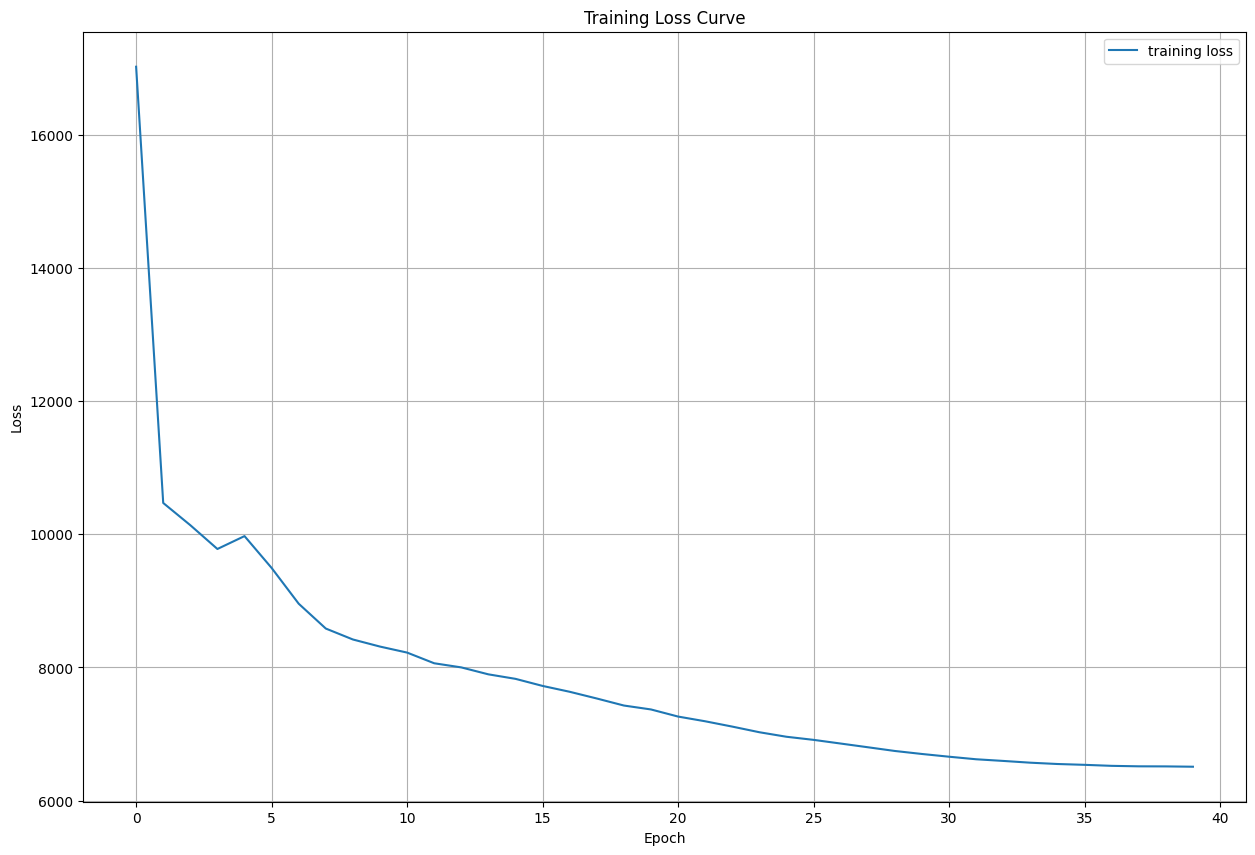

In [25]:
plt.figure(figsize=(15,10))
plt.plot(np.arange(len(loss_curve)), np.array(loss_curve), label="training loss")
plt.xlabel('Epoch') 
plt.ylabel('Loss')
plt.legend()
plt.title('Training Loss Curve')
plt.grid()
plt.show()

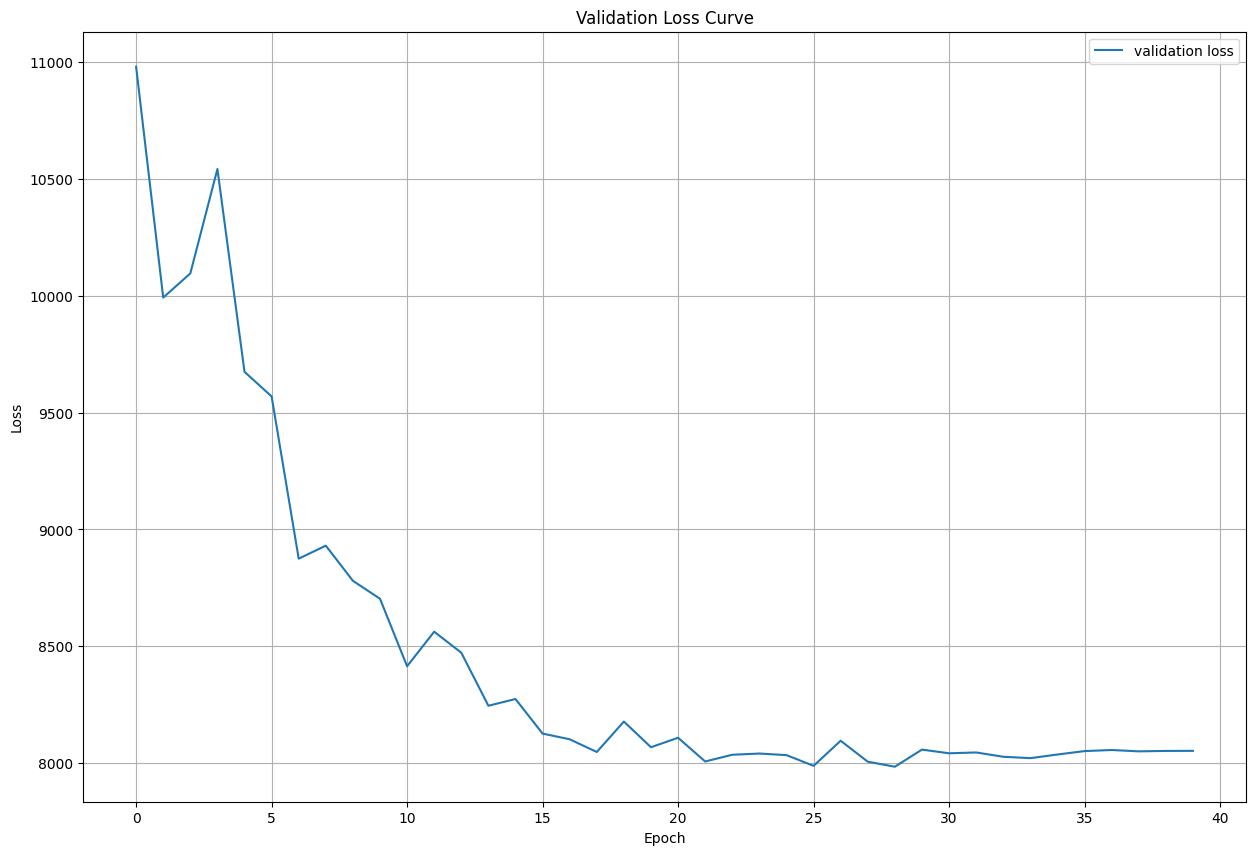

In [26]:
plt.figure(figsize=(15,10))
plt.plot(np.arange(len(validation_curve)), validation_curve, label="validation loss")
plt.xlabel('Epoch') 
plt.ylabel('Loss')
plt.legend()
plt.title('Validation Loss Curve')
plt.grid()
plt.show()

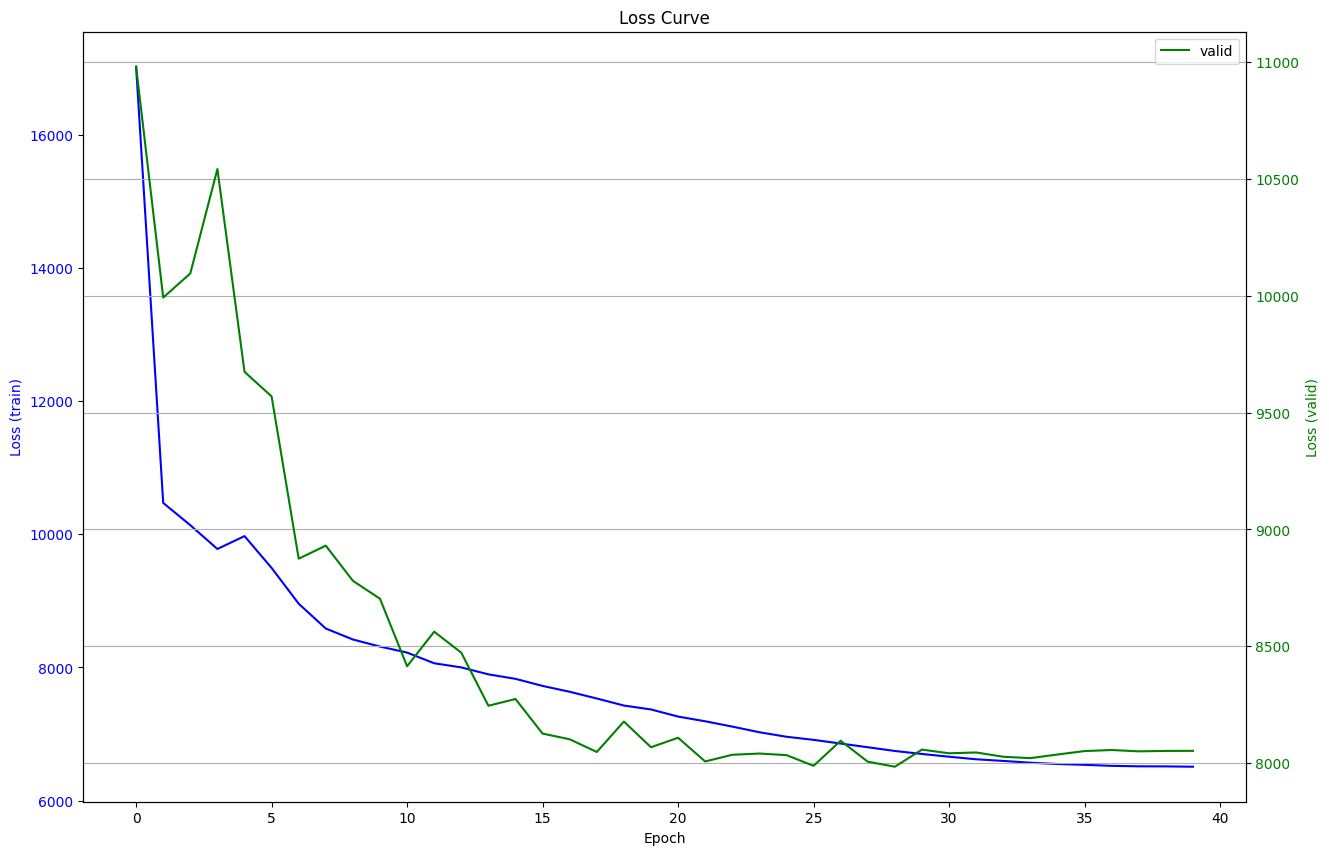

In [27]:
fig, ax1 = plt.subplots(figsize=(15, 10))

ax1.plot(np.arange(len(loss_curve)), np.array(loss_curve), 'b-', label='train')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss (train)', color='b') 
ax1.tick_params(axis='y', labelcolor='b')  # Color of y-ticks

ax2 = ax1.twinx()

ax2.plot(np.arange(len(validation_curve)), validation_curve, 'g-', label='valid')
ax2.set_ylabel('Loss (valid)', color='g')  # Label for the second y-axis
ax2.tick_params(axis='y', labelcolor='g')  # Color of y-ticks

plt.title('Loss Curve')
plt.legend()
plt.grid()
plt.show()

In [28]:
print(loss_curve)
print(validation_curve)

[17027.2073203125, 10471.815078125, 10137.697359375, 9780.099921875, 9973.769609375, 9495.3382578125, 8957.6581875, 8584.5110625, 8420.12703515625, 8313.5717109375, 8223.354015625, 8062.7781953125, 8000.653765625, 7896.355625, 7828.6773828125, 7722.32985546875, 7634.29636328125, 7533.3471171875, 7427.6660234375, 7368.733265625, 7261.86553125, 7191.0675546875, 7111.0708828125, 7026.3346640625, 6958.34803125, 6911.794875, 6856.41287890625, 6800.8366015625, 6744.7944296875, 6699.60881640625, 6658.573203125, 6620.1142265625, 6595.20657421875, 6568.7068515625, 6548.970171875, 6536.54717578125, 6521.317875, 6514.1561953125, 6512.97049609375, 6508.1441953125]
[10980.41015625, 9992.337890625, 10095.6904296875, 10542.578125, 9674.498046875, 9569.1865234375, 8874.7470703125, 8930.4130859375, 8780.03125, 8703.1806640625, 8414.39453125, 8562.1611328125, 8472.2099609375, 8245.251953125, 8274.0498046875, 8126.08642578125, 8101.6611328125, 8047.333984375, 8177.56982421875, 8067.6962890625, 8108.23242

# Predict
Use trained model for prediction.

In [29]:
def predict_processed(model, data, num_limit=10):

    model.eval()

    test_dataset = ProcessedMelSpectrogramDataset("test", data)

    data_loader = torch.utils.data.DataLoader(
        test_dataset, batch_size=1, collate_fn=test_dataset.collate
    )
    
    with tqdm.notebook.tqdm(
        data_loader,
        total=len(data_loader)) as batch_iterator:
        model.eval()

        for i, batch in enumerate(batch_iterator, start=1):
            if i > num_limit: break
            _, seq_length, n_mels = batch["ai_mel"].shape
            assert n_mels == 80
            pred = model.transform(batch)
            pred = (pred*sig_data_cuda) + mu_data_cuda # de-standardise
            assert pred.shape == (1, seq_length, n_mels)
            assert pred.squeeze().shape == (seq_length, n_mels)

            data_mel = (batch["data_mel"]*sig_data_cuda) + mu_data_cuda
            ai_mel = (batch["ai_mel"]*sig_cuda) + mu_cuda
            
            mel_to_audio(pred.squeeze(), f"test{i}_pred.wav")
            mel_to_audio(data_mel.squeeze(), f"test{i}_actual.wav")
            mel_to_audio(ai_mel.squeeze(), f"test{i}_input.wav")

In [30]:
predict_processed(transformer_encoder_model, dataset)

  0%|          | 0/453 [00:00<?, ?it/s]

In [31]:
test_dataset = ProcessedMelSpectrogramDataset("test", dataset)

In [32]:
label_decoder = {
    0: 'confused',
    1: 'default',
    2: 'emphasis',
    3: 'enunciated',
    4: 'essentials',
    5: 'happy',
    6: 'laughing',
    7: 'longform',
    8: 'sad',
    9: 'singing',
    10: 'whisper'
}

(80, 379)


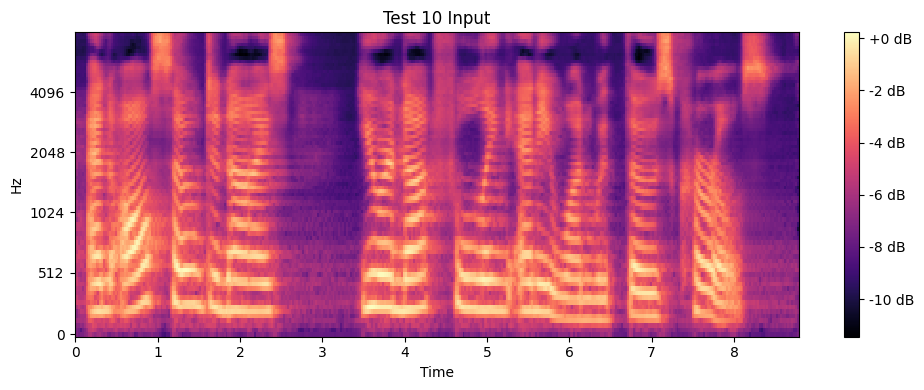

In [33]:
view_spectrogram(get_spectrogram("/kaggle/working/test10_input.wav"), title="Test 10 Input")

In [34]:
mel_to_audio(get_spectrogram("/kaggle/working/test10_input.wav"), display=True)

(80, 379)


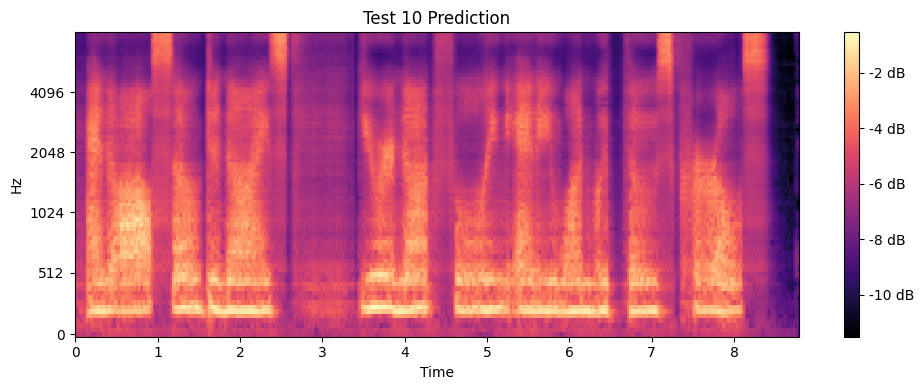

In [35]:
view_spectrogram(get_spectrogram("/kaggle/working/test10_pred.wav"), title="Test 10 Prediction")

In [36]:
mel_to_audio(get_spectrogram("/kaggle/working/test10_pred.wav"), display=True)

(80, 379)


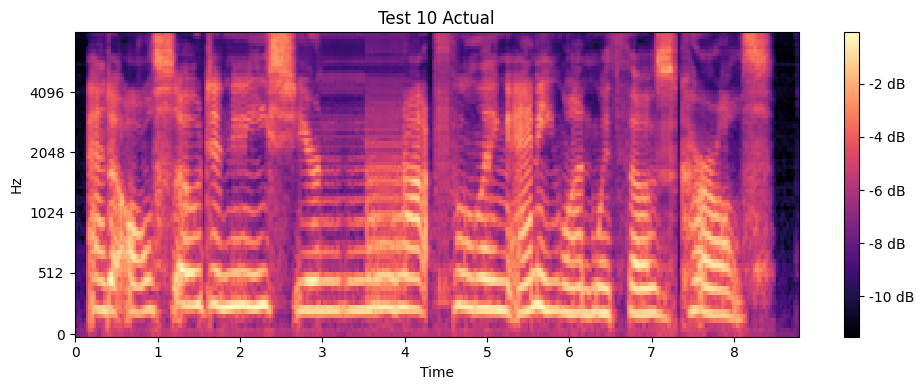

In [37]:
view_spectrogram(get_spectrogram("/kaggle/working/test10_actual.wav"), title="Test 10 Actual")

In [38]:
mel_to_audio(get_spectrogram("/kaggle/working/test10_actual.wav"), display=True)

In [39]:
label_decoder[test_dataset[8]["label"].item()]

'laughing'

(80, 222)


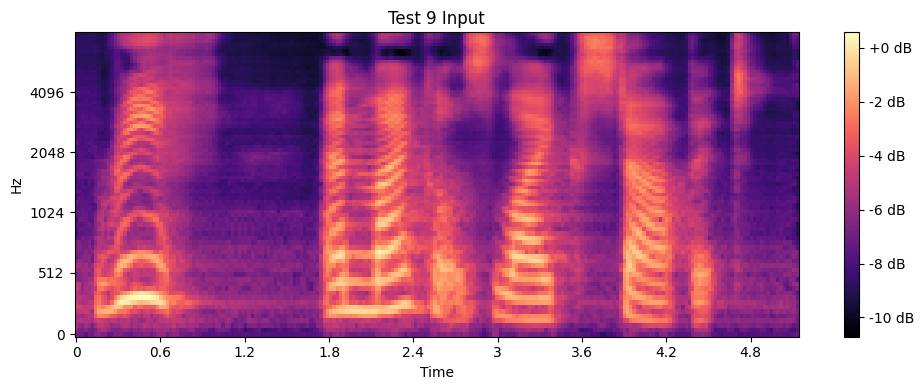

In [40]:
view_spectrogram(get_spectrogram("/kaggle/working/test9_input.wav"), title="Test 9 Input")

In [41]:
mel_to_audio(get_spectrogram("/kaggle/working/test9_input.wav"), display=True)

(80, 222)


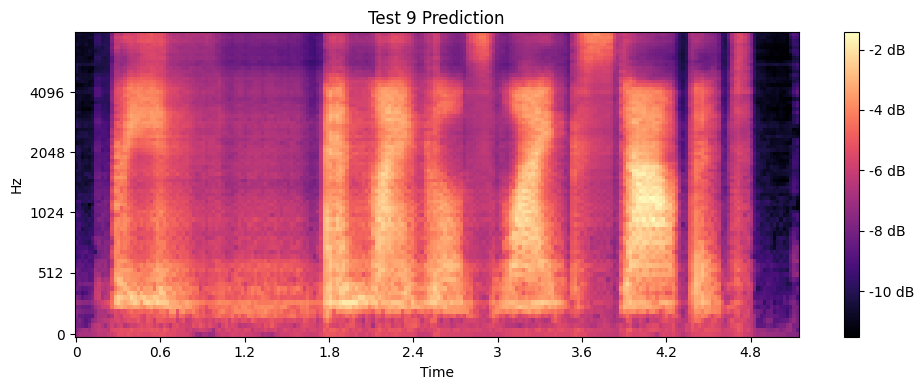

In [42]:
view_spectrogram(get_spectrogram("/kaggle/working/test9_pred.wav"), title="Test 9 Prediction")

In [43]:
mel_to_audio(get_spectrogram("/kaggle/working/test9_pred.wav"), display=True)

(80, 222)


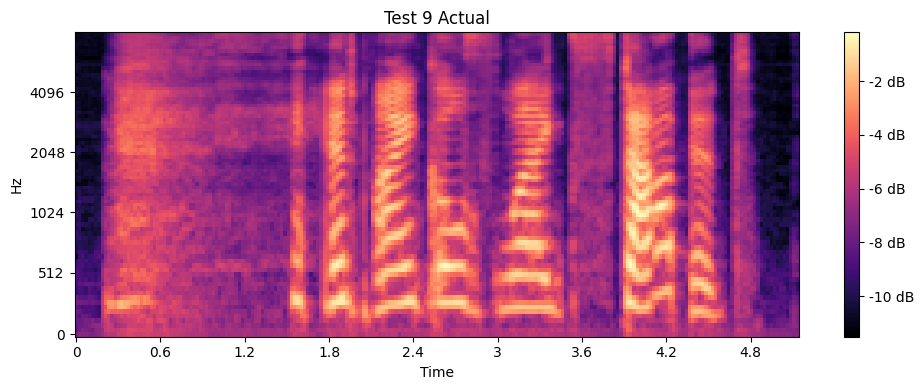

In [44]:
view_spectrogram(get_spectrogram("/kaggle/working/test9_actual.wav"), title="Test 9 Actual")

In [45]:
mel_to_audio(get_spectrogram("/kaggle/working/test9_actual.wav"), display=True)

In [46]:
mel_to_audio(get_spectrogram("/kaggle/working/test8_actual.wav"), display=True)

In [47]:
mel_to_audio(get_spectrogram("/kaggle/working/test8_input.wav"), display=True)

In [48]:
mel_to_audio(get_spectrogram("/kaggle/working/test8_pred.wav"), display=True)

In [49]:
mel_to_audio(get_spectrogram("/kaggle/working/test7_actual.wav"), display=True)

In [50]:
mel_to_audio(get_spectrogram("/kaggle/working/test7_pred.wav"), display=True)

In [51]:
mel_to_audio(get_spectrogram("/kaggle/working/test6_actual.wav"), display=True)

In [52]:
mel_to_audio(get_spectrogram("/kaggle/working/test6_pred.wav"), display=True)